## Predicting Housing Prices in Boston by Nikhil D'Mello

## Motivation

Can I classify housing listings under different rent buckets? 
What factors impact housing prices and to what degree?

Living in this city for 4 years drove my curiousity, coupled by the fact that housing prices here are outrageously high. I began thinking of all the different datapoints I could collect from housing listings. I wanted to predict what rent bucket (Target Variable) that apartments would fall under based on my features: Bedrooms, Bathrooms, Area (in square ft), and Distance (from Seaport, in miles). 

I chose to solve this problem with (multiclass) classification techniques using price buckets. I will acknowledge that there is some loss of information using these price buckets. Furthermore, I conducted regression techniques to predict price as a continuous value, but these performed poorly compared to classification.

<img src="assets/boston-map-links-6.jpg">

## Part 1: Data Scraping, Preprocessing, and Cleaning

This script pulls HTML files from each page of Craigslist i.e. Page 1/200. At the time of posting there were 120 pages of housing listings so I hardcoded that value.

In [2]:
import urllib.request as urllib
from bs4 import BeautifulSoup
import pandas as pd
from geopy.distance import geodesic
import time
import random
import numpy as np 

In [ ]:
apt_tags_list = []

def get_apt_tags_list_from_craigslist(url):
    """Creates a list of apartment listing tags based on each search query. There are 
    120 results per page. This function loops to the next page and appends all the tags on that page."""
    for page in range(0, 2600, 120):
        html = urllib.urlopen(url + str(page))
        soup = BeautifulSoup(html.read())
        
        apt_tags_list.append(soup.body.find_all("div", {'class':"result-info"}))
    return apt_tags_list

In [ ]:
df_rental = pd.DataFrame(columns = ["URL", "Date", "Monthly Rent", "Bedrooms", "Bathrooms", "Area in sqft", "Distance"])

In [ ]:
apt_tags_list = get_apt_tags_list_from_craigslist("https://boston.craigslist.org/search/gbs/apa?s=")

Distance from the most expensive part of Boston is an important metric that can affect housing prices.

This function gets the latitude and longitude points from the Google Maps widget on each housing listing so we can calculate how far they are from the South Boston Waterfront, where rent is the highest in the city. This function uses GeoPy to calculate the geodesic distance between two (x,y) coordinates. It returns a NoneValue when it doesn't find the maps widget on the listing.

In [ ]:
seaport_gps_coords = (42.34504340030401, -71.04424594176619)

def get_distance_from_seaport_in_miles(individual_posting_url):
    """Gets the lat and long points from the Google Maps widget within each posting HTML file."""
    html = urllib.urlopen(individual_posting_url)
    soup = BeautifulSoup(html.read())
   
    tag = soup.find("div", {'id':'map'})
    if tag is None:
        return None
    else:
        coords = (tag['data-latitude'], tag['data-longitude'])
    
    distance_in_miles = geodesic(seaport_gps_coords, coords).miles
    return round(distance_in_miles, 5)

In [ ]:
print(get_distance_from_seaport_in_miles('https://boston.craigslist.org/gbs/apa/d/everett-private-bedroom-248-week-or/7514123398.html'))

This script loops through the pages list and scrapes housing listing data available on each page. It took around 12 hours to run, so I suggest not running this cell.

In [ ]:
for apt_tags in apt_tags_list:
    for result in apt_tags:

        time.sleep(random.uniform(0.7,0.9))

        individual_posting_url = result.find("a").get("href")
        
        try:
            soup_posting = BeautifulSoup(urllib.urlopen(individual_posting_url).read())
        except ConnectionResetError:
            time.sleep(3)

        distance = get_distance_from_seaport_in_miles(individual_posting_url)
        if distance == None:
            distance = ''
        else:
            distance = get_distance_from_seaport_in_miles(individual_posting_url)

        span_tags = soup_posting.find_all("span", "shared-line-bubble")
        area = ''
        if span_tags is None:
            bedrooms = ''
            bathrooms = ''
            area = ''
        else:
            for tag in span_tags:
                if '/' in tag.get_text():
                    bedrooms = int(tag.get_text().split('BR')[0].strip())
                    try:
                        bathrooms = float(tag.get_text().split('/')[1].strip().split('Ba')[0])
                    except:
                        bathroom = ''
                if 'ft' in tag.get_text():
                    area = int(tag.get_text().split('ft')[0].strip())

        price = float(result.find("span", "result-price").get_text()[1:].replace(',',''))   
        date = result.find("time", "result-date").get("title")

        df_rental = df_rental.append({"URL":individual_posting_url, "Date": date, "Monthly Rent":price, "Bedrooms":bedrooms, "Bathrooms":bathrooms, "Area in sqft":area, "Distance":distance}, ignore_index=True)

In [ ]:
df_rental

In [ ]:
df_rental.to_csv("datasets/ndmello_boston_rentals_3.csv")

### Refresh script from here to pull CSV data.

In [5]:
df_rental = pd.read_csv('datasets/ndmello_boston_rentals_3_RAW.csv')
df_rental = df_rental.replace(r'^\s*$', np.nan, regex=True)
df_rental.reset_index(drop=True, inplace=True)
df_rental = df_rental.iloc[:, 1:]

df = df_rental.dropna()
df = df.rename(columns={'Monthly Rent': 'Rent', 'Area in sqft': 'Area'})
df.reset_index(drop=True, inplace=True)
df

,URL,Date,Rent,Bedrooms,Bathrooms,Area,Distance
0,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 05:48:38 PM,7000.0,3,1.0,800.0,3.16906
1,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 05:25:21 PM,3350.0,2,1.0,850.0,5.24023
2,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 04:41:21 PM,2650.0,2,1.0,1025.0,4.36249
3,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 04:22:55 PM,4115.0,2,1.0,1001.0,4.71250
4,https://boston.craigslist.org/gbs/apa/d/revere...,Thu 28 Jul 04:10:46 PM,1895.0,1,1.0,750.0,5.14923
...,...,...,...,...,...,...,...
1196,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 09:21:23 AM,3800.0,4,2.0,1000.0,3.58082
1197,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 08:56:10 AM,2500.0,2,1.0,1200.0,4.71505
1198,https://boston.craigslist.org/gbs/apa/d/nonant...,Tue 28 Jun 08:01:04 AM,5600.0,3,2.5,2000.0,8.04295
1199,https://boston.craigslist.org/gbs/apa/d/west-m...,Tue 28 Jun 06:55:01 AM,1400.0,1,1.0,1000.0,7.01947


In [6]:
df.to_csv("datasets/ndmello_boston_rentals_4.csv")

## Part 2: Data Mining

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import seaborn as sns

In [8]:
df.describe()

,Rent,Bedrooms,Bathrooms,Area,Distance
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.00000
mean,3249.678601,2.121565,1.407161,1130.847627,6.13793
std,1329.921117,1.280056,0.606835,955.223639,46.77803
min,1.000000,0.000000,1.000000,1.000000,0.29013
25%,2400.000000,1.000000,1.000000,700.000000,2.37380
50%,3050.000000,2.000000,1.000000,1000.000000,4.01651
75%,3875.000000,3.000000,2.000000,1300.000000,5.35542
max,11000.000000,8.000000,4.000000,9999.000000,1147.76403


<AxesSubplot:>

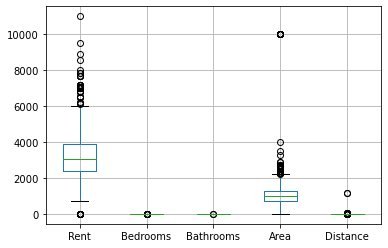

In [9]:
df.boxplot()

### Anomaly detection

Descriptive statistics show that there are anomalies in the data. The below cell is run multiple times (until Rent mean stops changing (2963.14)) to get retain data with z scores < 2.5 to filter out anomalies.

In [16]:
from scipy import stats

z_scores = stats.zscore(df[['Rent', 'Area', 'Distance', 'Bedrooms', 'Bathrooms']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2.5).all(axis=1)
df = df[filtered_entries]
df.describe()

,Rent,Bedrooms,Bathrooms,Area,Distance
count,924.000000,924.000000,924.000000,924.000000,924.000000
mean,2963.140693,1.806277,1.222944,897.323593,3.829005
std,881.493305,1.063694,0.401208,312.399372,1.893473
min,795.000000,0.000000,1.000000,150.000000,0.290130
25%,2393.750000,1.000000,1.000000,654.500000,2.263260
50%,2950.000000,2.000000,1.000000,900.000000,3.880540
75%,3600.000000,2.000000,1.000000,1100.000000,5.231820
max,5088.000000,4.000000,2.000000,1600.000000,8.450520


Removed data more than 2.5 standard deviations away from the mean. Attempted 3 but led to negative values when manually calculating Rent with Mean and Std.

<AxesSubplot:>

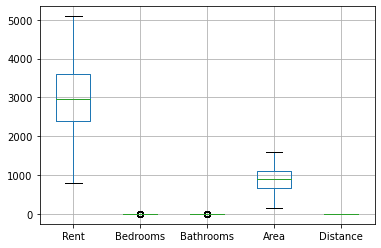

In [17]:
df.boxplot()

### Class balancing and binning

In [18]:
rent_bucket = pd.qcut(df['Rent'], 3, labels=['(795, 2520]','(2520, 3300]','(3300, 5100]'])

df = df.assign(Rent_bucket=rent_bucket.values)
df

,URL,Date,Rent,Bedrooms,Bathrooms,Area,Distance,Rent_bucket
1,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 05:25:21 PM,3350.0,2,1.0,850.0,5.24023,"(3300, 5100]"
2,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 04:41:21 PM,2650.0,2,1.0,1025.0,4.36249,"(2520, 3300]"
3,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 04:22:55 PM,4115.0,2,1.0,1001.0,4.71250,"(3300, 5100]"
4,https://boston.craigslist.org/gbs/apa/d/revere...,Thu 28 Jul 04:10:46 PM,1895.0,1,1.0,750.0,5.14923,"(795, 2520]"
5,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 03:33:46 PM,3255.0,2,1.5,657.0,4.71250,"(2520, 3300]"
...,...,...,...,...,...,...,...,...
1192,https://boston.craigslist.org/gbs/apa/d/east-b...,Tue 28 Jun 01:13:14 PM,1950.0,2,1.0,900.0,3.06572,"(795, 2520]"
1195,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 10:13:46 AM,3625.0,4,2.0,1300.0,4.77274,"(3300, 5100]"
1196,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 09:21:23 AM,3800.0,4,2.0,1000.0,3.58082,"(3300, 5100]"
1197,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 08:56:10 AM,2500.0,2,1.0,1200.0,4.71505,"(795, 2520]"


In [19]:
df['Rent_bucket'].value_counts()

(2520, 3300]    309
(795, 2520]     308
(3300, 5100]    307
Name: Rent_bucket, dtype: int64

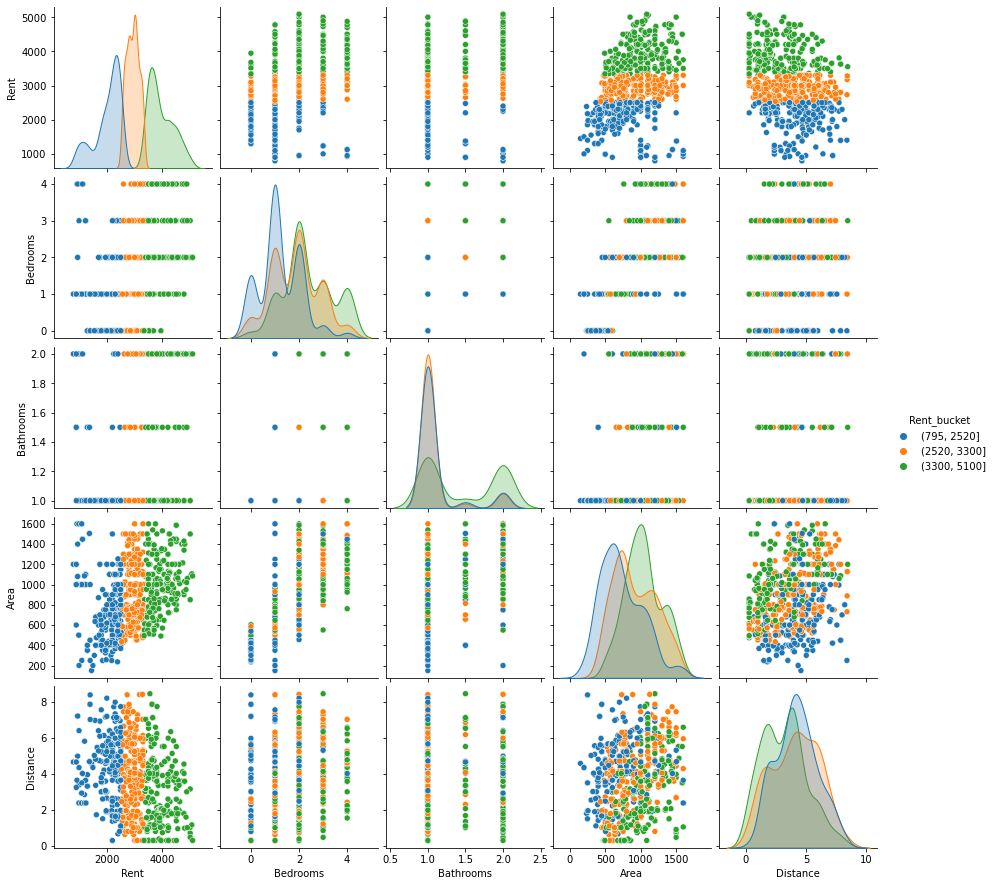

In [20]:
sns.pairplot(df, hue='Rent_bucket')

In [21]:
df[["Rent", "Bedrooms"]].groupby("Bedrooms").mean()

,Rent
Bedrooms,
0,2342.738636
1,2566.189655
2,3138.344311
3,3383.240876
4,3678.333333


<AxesSubplot:xlabel='Bedrooms', ylabel='Rent'>

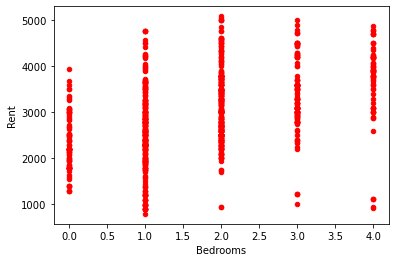

In [22]:
df.plot.scatter(x='Bedrooms', y='Rent', c="red")

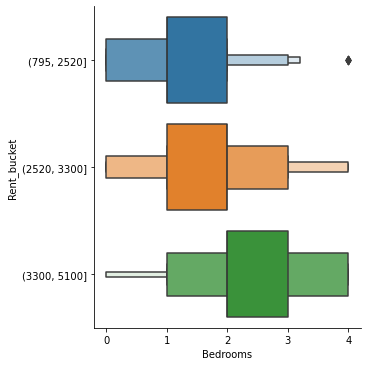

In [23]:
sns.catplot(x='Bedrooms', y='Rent_bucket', kind="boxen", data=df)

Saving our dataset which is ready for statistical modeling.

In [25]:
df.to_csv("datasets/ndmello_boston_rentals_4.csv")
df

,URL,Date,Rent,Bedrooms,Bathrooms,Area,Distance,Rent_bucket
1,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 05:25:21 PM,3350.0,2,1.0,850.0,5.24023,"(3300, 5100]"
2,https://boston.craigslist.org/gbs/apa/d/somerv...,Thu 28 Jul 04:41:21 PM,2650.0,2,1.0,1025.0,4.36249,"(2520, 3300]"
3,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 04:22:55 PM,4115.0,2,1.0,1001.0,4.71250,"(3300, 5100]"
4,https://boston.craigslist.org/gbs/apa/d/revere...,Thu 28 Jul 04:10:46 PM,1895.0,1,1.0,750.0,5.14923,"(795, 2520]"
5,https://boston.craigslist.org/gbs/apa/d/cambri...,Thu 28 Jul 03:33:46 PM,3255.0,2,1.5,657.0,4.71250,"(2520, 3300]"
...,...,...,...,...,...,...,...,...
1192,https://boston.craigslist.org/gbs/apa/d/east-b...,Tue 28 Jun 01:13:14 PM,1950.0,2,1.0,900.0,3.06572,"(795, 2520]"
1195,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 10:13:46 AM,3625.0,4,2.0,1300.0,4.77274,"(3300, 5100]"
1196,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 09:21:23 AM,3800.0,4,2.0,1000.0,3.58082,"(3300, 5100]"
1197,https://boston.craigslist.org/gbs/apa/d/somerv...,Tue 28 Jun 08:56:10 AM,2500.0,2,1.0,1200.0,4.71505,"(795, 2520]"


## Part 3: Statistical Modeling

In [26]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint

SEED = 42

### Linear Regression

In [27]:
x_features = ['Bedrooms', 'Bathrooms', 'Area', 'Distance']
y_feat = 'Rent'
X = df.loc[:, x_features].values
y = df.loc[:, y_feat].values

reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

r2 = r2_score(y_true=y, y_pred=y_pred)
print('R2 Score: {:.3f}'.format(r2))
print('{:.2f}%'.format(r2*100), 'of the variation in price is explained by the variations in the features.')

R2 Score: 0.339
33.88% of the variation in price is explained by the variations in the features.


In [28]:
feat_coef_dict = dict(zip(x_features, reg.coef_))

print('Coefficients of features: ' '\n')
pprint(feat_coef_dict)

print('\n')
print('If area increases by 1 square ft, the price increases by', '{:.2f}'.format(feat_coef_dict['Area']))
print('If bathrooms increase by 1, the price increases by', '{:.2f}'.format(feat_coef_dict['Bathrooms']))
print('If bedrooms increase by 1, the price increases by', '{:.2f}'.format(feat_coef_dict['Bedrooms']))
print('If distance decreases by 1 mile, the price decreases by', '{:.2f}'.format(feat_coef_dict['Distance']))

Coefficients of features: 

{'Area': 0.2955340671162503,
 'Bathrooms': 339.31493981994913,
 'Bedrooms': 314.1935080884751,
 'Distance': -156.44017123543787}


If area increases by 1 square ft, the price increases by 0.30
If bathrooms increase by 1, the price increases by 339.31
If bedrooms increase by 1, the price increases by 314.19
If distance decreases by 1 mile, the price decreases by -156.44


<img src="assets/regression_excel.png">

The intercept coefficient is 2314, which means that there is a lot that is unexplained by the variations in the features. Coefficient p-values < 0.05, so the coefficients are statistically significant. 

In [29]:
var_dict = dict(zip(x_features, np.var(X, axis=0)))

print('Variance of features: ' '\n')
pprint(var_dict)

Variance of features: 

{'Area': 97487.74701912446,
 'Bathrooms': 0.16079393189782795,
 'Bedrooms': 1.130220338824235,
 'Distance': 3.5813597311541643}


Variance of features are quite different. We cannot compare these values until we normalize the values so that the variance of each feature is 1.

### Classification

#### Decision Tree Classifier

In [30]:
x_features = ['Bedrooms', 'Bathrooms', 'Area', 'Distance']
target_feature = 'Rent_bucket'

X = df.loc[:, x_features].values
y = df.loc[:, target_feature].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

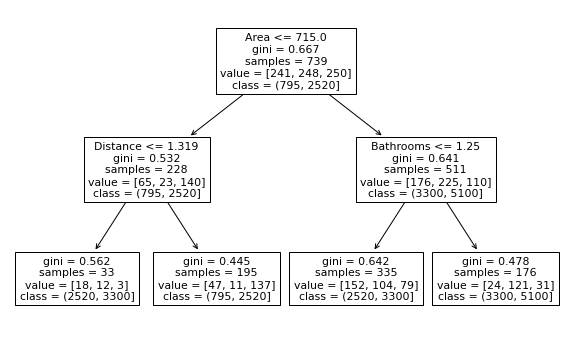

In [31]:
tree_classifier = DecisionTreeClassifier(max_depth=2, random_state=SEED)
tree_classifier.fit(X_train, y_train)

fig = plt.figure()
fig.set_size_inches(10, 6)

plot_tree(tree_classifier, 
          feature_names=x_features,
          class_names=np.unique(y));

In [32]:
y_pred = tree_classifier.predict(X_test)

print('Decision Tree Classifier: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Decision Tree Classifier: 62.7%


### Ensemble Learning

#### Random Forests

In [33]:
x_features = ['Bedrooms', 'Bathrooms', 'Area', 'Distance']
target_feature = 'Rent_bucket'

X = df.loc[:, x_features].values
y = df.loc[:, target_feature].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [34]:
kfold = StratifiedKFold(n_splits=10)

y_pred = np.empty_like(y)

random_forest_classifier = RandomForestClassifier(max_depth=7, random_state=SEED)

for train_idx, test_idx in kfold.split(X, y):
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    
    X_test = X[test_idx, :]
    
    random_forest_classifier.fit(X_train, y_train)
    
    y_pred[test_idx] = random_forest_classifier.predict(X_test)

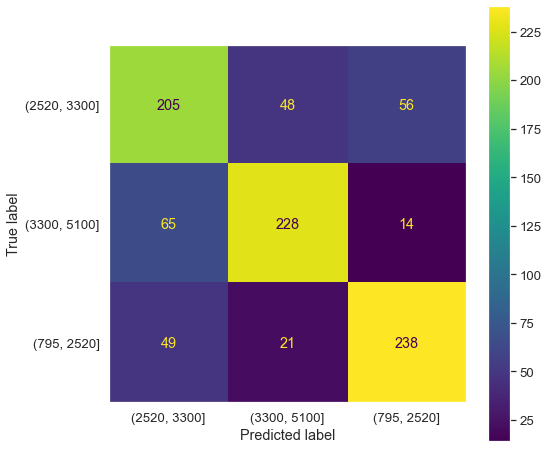

In [35]:
y_feat_list = np.unique(y)
sns.set(font_scale=1.2)
confusion_matrix_info = confusion_matrix(y_true=y, y_pred=y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix_info, display_labels=y_feat_list)
confusion_matrix_display.plot()
plt.gcf().set_size_inches(8, 8)
plt.grid(False)

In [36]:
print('Random forest: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Random forest: 72.6%


In [37]:
print('Random forest classification report:', '\n\n', classification_report(y, y_pred))

Random forest classification report: 

               precision    recall  f1-score   support

(2520, 3300]       0.64      0.66      0.65       309
(3300, 5100]       0.77      0.74      0.75       307
 (795, 2520]       0.77      0.77      0.77       308

    accuracy                           0.73       924
   macro avg       0.73      0.73      0.73       924
weighted avg       0.73      0.73      0.73       924



### Feature standardization (before classification excl. trees)

Decision trees do not require standardization because they aren't sensitive to the variance in data.

In [38]:
X = df.loc[:, x_features].values
y = df.loc[:, target_feature].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fit scaler only on training data
# Standardise train and test sets with that scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Voting Classifier - Logistic Regression, KNN, & Decision Tree

In [39]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [40]:
lr = LogisticRegression(multi_class='multinomial', random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)

classifiers = [('Logistic Regression', lr),
               ('K Nearest Neighbours', knn),
               ('Decision Tree Classifier', dt)]

for clf_name, clf in classifiers:
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print('{:s} : {:.1f}%'.format(clf_name, accuracy_score(y_test, y_pred)*100))

Logistic Regression : 62.2%
K Nearest Neighbours : 70.3%
Decision Tree Classifier : 81.1%


In [41]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train_scaled, y_train)
y_pred = vc.predict(X_test_scaled)
print('Voting Classifier: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Voting Classifier: 79.5%


### ROC Curves and OneVsRest (OvR) Strategy

ROC AUC Scores seem to be the [most appropriate metric](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) for multiclass classification. Since we don't have class imbalance, we don't need to use F1 scores.

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from itertools import cycle

#### OvR - DecisionTreeClassifier

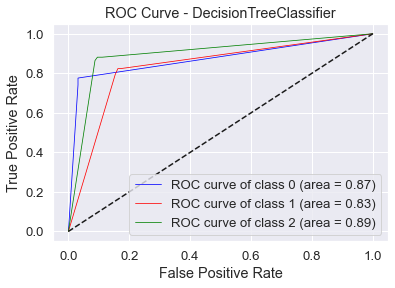

In [43]:
X = df.loc[:, x_features].values
y = df.loc[:, target_feature].values

labels=['(795, 2520]','(2520, 3300]','(3300, 5100]']

y = label_binarize(y, classes=labels)
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fits one DTClassifier per CLASS
clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))
y_pred = clf.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.75,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()

In [44]:
print('Area under curve (AUC) scores: \n')
for i, label in zip(range(3), labels):
    print(label, ':',  '{:.3f}'.format(roc_auc[i]), '\n')

avg_auc_score = (sum(roc_auc.values())/len(roc_auc)) * 100
print('Average AUC score: {:.1f} %'.format(avg_auc_score))

Area under curve (AUC) scores: 

(795, 2520] : 0.872 

(2520, 3300] : 0.831 

(3300, 5100] : 0.895 

Average AUC score: 86.6 %


In [45]:
clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=SEED))

scores = cross_val_score(clf, X, y, cv=50, scoring='roc_auc')
print(np.mean(scores))

0.8516363888169444


#### OvR - KNN

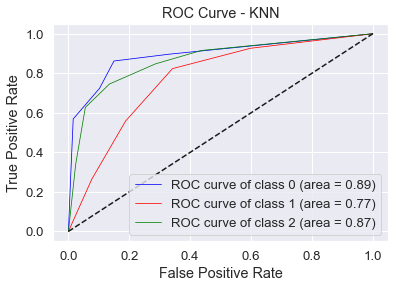

In [46]:
X = df.loc[:, x_features].values
y = df.loc[:, target_feature].values

labels=['(795, 2520]','(2520, 3300]','(3300, 5100]']

y = label_binarize(y, classes=labels)
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = OneVsRestClassifier(KNN())
y_pred = clf.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.75,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()

In [47]:
print('Area under curve (AUC) scores: \n')
for i, label in zip(range(3), labels):
    print(label, ':',  '{:.3f}'.format(roc_auc[i]), '\n')

avg_auc_score = (sum(roc_auc.values())/len(roc_auc)) * 100
print('Average AUC score: {:.1f} %'.format(avg_auc_score))

Area under curve (AUC) scores: 

(795, 2520] : 0.892 

(2520, 3300] : 0.774 

(3300, 5100] : 0.866 

Average AUC score: 84.4 %


In [50]:
scaler = StandardScaler()
clf = KNN()

pipeline = Pipeline([('StandardScaler', scaler),
                     ('Classifier', clf)])

scores = cross_val_score(pipeline, X, y, cv=31, scoring='roc_auc')
print(scores)
print(np.mean(scores))

[0.99199585 0.96634651 0.98533951 0.95397931 0.97541887 0.99417649
 0.98703042 0.97145612 0.99608025 0.75415188 0.73051487 0.86661376
 0.84370016 0.68519114 0.78962682 0.85201839 0.84792314 0.83627656
 0.89749296 0.90487812 0.80731764 0.71865032 0.79037398 0.79431384
 0.87887414 0.74941032 0.74061772 0.7904902  0.90073468 0.81097308
 0.84358466]
0.8598565064098023
